## Prep

In [258]:
# Import packages
import pandas as pd
import plotly.graph_objects as go
import networkx as nx
from ds_common_utils.aux.io.snowflake_tools import SnowflakeTools
from math import log
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain
import numpy as np

In [259]:
# Get connection
con = SnowflakeTools().get_snowflake_ctx(
     method = 'token',
    user = '250807',
    role = 'INSIGHT_ANALYST_MERCH_DE_GENERAL_PRD',
    warehouse = 'INSIGHT_ANALYST_WH'
)
with open('sql/item_association.sql', 'r') as query:
        df = pd.read_sql_query(query.read(), con)

snowflake_tools - 2025-06-20 17:44:09.986085+10:00 - Generating new token with 'INSIGHT_ANALYST_MERCH_DE_GENERAL_PRD' role and 'SESSION:ROLE-ANY' scope...


snowflake_tools - 2025-06-20 17:44:15.529312+10:00 - Saved token with '2025-06-20 21:44:15+10:00' expiry...


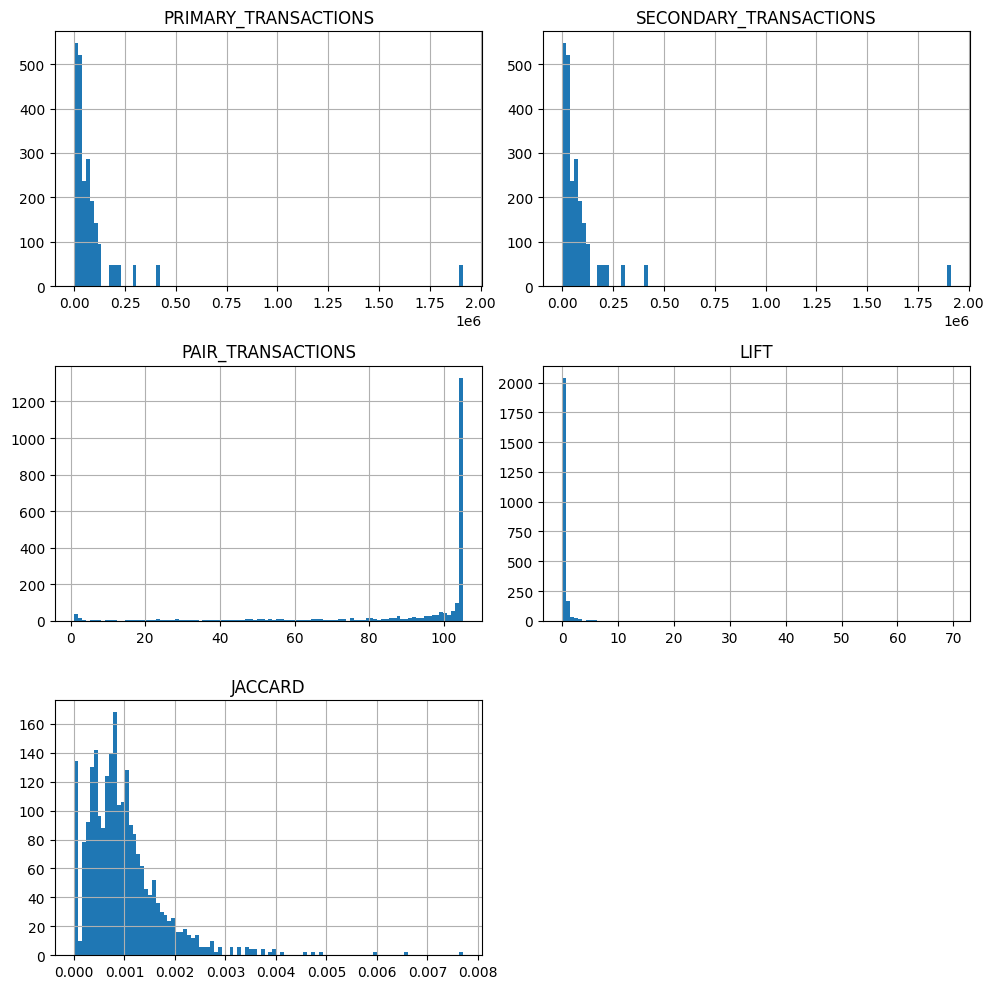

In [519]:
# Plot histograms of numerical columns
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols].hist(bins=100, figsize=(10, 10), layout=(3, 2))
plt.tight_layout()
plt.show()

## Parameter Tuning

In [908]:
TRX_THRESHOLD = 50 # Min N frequent pairs
QUANTILE = 0.975 # Nth percentile of metric similarity
TOP_N = 2 # top-N associated item classes per primary class
RESO = 1 # >1.0 → more, smaller communities
METRIC = 'LIFT' # LIFT or JACCARD

## Working

In [909]:
filtered_df = df[(df['PRIMARY_ID'] != '300 PEST CONTROL' ) & ( df['SECONDARY_ID']!='300 PEST CONTROL')]

filtered_df = filtered_df[filtered_df['PAIR_TRANSACTIONS'] >= TRX_THRESHOLD]
threshold = filtered_df[METRIC].quantile(QUANTILE)
filtered_df = filtered_df[filtered_df[METRIC] >= threshold]
top_edges = filtered_df.sort_values(METRIC, ascending=False).groupby('PRIMARY_ID').head(TOP_N)


In [910]:
filtered_df.sort_values(by='PAIR_TRANSACTIONS', ascending=False)

,PRIMARY_ID,SECONDARY_ID,PRIMARY_TRANSACTIONS,SECONDARY_TRANSACTIONS,TRX_START_MONTH,TRX_END_MONTH,PAIR_TRANSACTIONS,LIFT,JACCARD
1633,300 STRUCTURAL TIMBER,300 INDOOR TIMBER AND BOARDS,4571,25734,2020-07-01,2025-06-01,105,1.707615,0.003477
745,300 INDOOR TIMBER AND BOARDS,300 STRUCTURAL TIMBER,25734,4571,2020-07-01,2025-06-01,105,1.707615,0.003477
1639,300 STRUCTURAL TIMBER,300 OUTDOOR TIMBER,4571,12799,2020-07-01,2025-06-01,103,3.367978,0.005965
1031,300 OUTDOOR TIMBER,300 STRUCTURAL TIMBER,12799,4571,2020-07-01,2025-06-01,103,3.367978,0.005965
80,300 BUILDING MATERIALS,300 STRUCTURAL TIMBER,10924,4571,2020-07-01,2025-06-01,101,3.869437,0.006561
1619,300 STRUCTURAL TIMBER,300 BUILDING MATERIALS,4571,10924,2020-07-01,2025-06-01,101,3.869437,0.006561
128,300 BUILDING SUPPLIES,300 STRUCTURAL TIMBER,17507,4571,2020-07-01,2025-06-01,100,2.390542,0.004550
1620,300 STRUCTURAL TIMBER,300 BUILDING SUPPLIES,4571,17507,2020-07-01,2025-06-01,100,2.390542,0.004550
1415,300 POWER TOOLS,300 TOOL STORAGE,19964,6223,2020-07-01,2025-06-01,97,1.493632,0.003718
999,300 OUTDOOR TIMBER,300 BUILDING MATERIALS,12799,10924,2020-07-01,2025-06-01,97,1.327191,0.004106


In [911]:
mode='lines',
line_shape='spline'
    
# Build node size map from your DataFrame
node_size_map = dict(zip(top_edges['PRIMARY_ID'], top_edges['PRIMARY_TRANSACTIONS']))

# Convert values to NumPy array
sizes = np.array(list(node_size_map.values()))

# Use np.ptp instead of .ptp()
norm_sizes = (sizes - sizes.min()) / np.ptp(sizes)  # scale to 0–1
scaled_sizes = 10 + norm_sizes * 30                 # scale to 10–40

# Final size map: Product ID → Scaled Size
scaled_size_map = dict(zip(node_size_map.keys(), scaled_sizes))

# Step 1: Build the full graph
G = nx.Graph()
for _, row in top_edges.iterrows():
    G.add_edge(row['PRIMARY_ID'], row['SECONDARY_ID'], weight=row[METRIC])

# Step 2: Louvain community detection
partition = community_louvain.best_partition(G, weight=METRIC, resolution=RESO)

# Step 3: Layout
pos = nx.spring_layout(G, weight='weight', seed=42
                      )

# Step 4: Edge trace (no filter on weight)
edge_x, edge_y = [], []
for u, v in G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=1, color='gray'),
    hoverinfo='none',
    mode='lines'
)

# Step 5: Node trace with Louvain cluster coloring
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']  # Extend if you expect >10 clusters

node_x, node_y, node_color, node_size, hover_text = [], [], [], [], []

for node in G.nodes():
    x, y = pos[node]
    cluster = partition[node]
    size = scaled_size_map.get(node, 10)  # default to small if missing

    node_x.append(x)
    node_y.append(y)
    node_color.append(color_list[cluster % len(color_list)])
    node_size.append(size)
    hover_text.append(f"Product ID: {node}<br>Cluster: {cluster}<br>Transactions: {int(size)}")

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    hoverinfo='text',
    text=[str(node) for node in G.nodes()],
    textposition='top center',
    marker=dict(
        color=node_color,
        size=node_size,  # <--- size now dynamic!
        line=dict(width=2, color='black')
    ),
    textfont=dict(
    size=16,          # increase for visibility
    color='black',
    family='Arial'
)
)
# Step 6: Plot
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        width=1200,          # increase width
    height=800, 
        title=dict(text='Louvain Product Clustering (All Edges)', x=0.5, font=dict(size=16)),
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=20, r=20, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
)

## Results

In [912]:
fig.show()

In [913]:
# Merge community partition info with filtered edges
partition_df = pd.DataFrame.from_dict(partition, orient='index', columns=['segment']).reset_index()
partition_df.rename(columns={'index': 'PRIMARY_ID'}, inplace=True)

# Merge and deduplicate
labelled_df = filtered_df.merge(partition_df, on='PRIMARY_ID', how='left')
labelled_df = labelled_df[['PRIMARY_ID', 'SECONDARY_ID', 'PRIMARY_TRANSACTIONS', 'SECONDARY_TRANSACTIONS', 'PAIR_TRANSACTIONS', METRIC, 'segment']].drop_duplicates()
labelled_df = labelled_df.sort_values(by=['segment', METRIC]).reset_index(drop=True)

# Expand display limits
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
display(labelled_df)

,PRIMARY_ID,SECONDARY_ID,PRIMARY_TRANSACTIONS,SECONDARY_TRANSACTIONS,PAIR_TRANSACTIONS,LIFT,segment
0,HIRE SHOP DT,301 BATHROOM,2048,36739,50,1.265987,0
1,301 BATHROOM,HIRE SHOP DT,36739,2048,50,1.271253,0
2,300 DOORS AND WINDOWS,300 TRANSPORT AND MOVING,795,88667,50,1.356938,1
3,300 TRANSPORT AND MOVING,300 DOORS AND WINDOWS,88667,795,50,1.356938,1
4,300 DOORS AND WINDOWS,300 HOOKS LEGS PROTECT SAFETY,795,124401,78,1.508769,1
5,300 HOOKS LEGS PROTECT SAFETY,300 DOORS AND WINDOWS,124401,795,78,1.508769,1
6,300 DOORS AND WINDOWS,300 HAND TOOLS,795,71868,54,1.808050,1
7,300 HAND TOOLS,300 DOORS AND WINDOWS,71868,795,54,1.808050,1
8,300 DOORS AND WINDOWS,300 FIXINGS,795,88979,91,2.460968,1
9,300 FIXINGS,300 DOORS AND WINDOWS,88979,795,91,2.460968,1


**Segment 0 – Bathroom Renovation with Equipment Hire**
- HIRE SHOP DT
- 301 BATHROOM

Interpretation: Reflects commercial or residential bathroom upgrades where pest control is purchased alongside hire shop tools and washroom essentials.

**Segment 1 –  Doors, Fixtures & Final Fitout**
This group is strongly anchored around:
- 300 DOORS AND WINDOWS
- 300 TRANSPORT AND MOVING
- 300 HOOKS LEGS PROTECT SAFETY
- 300 HAND TOOLS
- 300 FIXINGS
- 300 TOOL ACCESSORIES
- 300 PAINT
- 300 SECURITY HARDWARE
- 300 INDOOR TIMBER AND BOARDS
- 300 BUILDING MATERIALS

Interpretation: Pest control here is bought as part of interior finishing, lock/seal installation, or property prep. Strong co-occurrence with hardware and consumables points to end-of-project sealing or even vacant property maintenance.

**Segment 2 – Heavy Structural and Site Prep**
- 300 STRUCTURAL TIMBER
- 300 WOODCARE
- 300 OUTDOOR TIMBER
- 300 TOOL STORAGE
- 300 CAFE DEPARTMENT
- 300 POWER TOOLS
- 300 BUILDING SUPPLIES
- 300 LADDERS STEEL AND ROOFING
- 300 INDOOR TIMBER AND BOARDS
- 300 BUILDING MATERIALS
- 300 DOORS AND WINDOWS

Interpretation: Indicates large-scale builds or site setup phases. Pest control appears as part of timber framing, protective treatments, or outdoor structural work.

**Segment 3 – Trade Supply Replenishment Runs**
- 300 TOOL STORAGE
- 300 OUTDOOR TIMBER
- 300 LADDERS STEEL AND ROOFING
- 300 STRUCTURAL TIMBER
- 300 POWER TOOLS
- 300 KITCHEN AND APPLIANCES
- 300 BUILDING MATERIALS

Interpretation: Suggests standard replenishment runs by trade professionals. Pest control is a secondary pickup added alongside tools, site ladders, and general fixtures.



**Summary:** Pest control is rarely bought alone, but typically part of broader build or renovation projects:
- Bathroom and hire gear – part of hygiene upgrades. (Segment 0)
- Doors, fixings, hardware – sealing and access control. (Segment 1&3)
- Timber and outdoor materials – structural or exterior work. (Segment 2)